In [181]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [182]:
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [183]:
df = pd.read_csv('https://api.covid19india.org/csv/latest/state_wise_daily.csv')
df

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,14-Mar-20,Recovered,9,0,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
2,14-Mar-20,Deceased,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15-Mar-20,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
4,15-Mar-20,Recovered,4,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,24-Jun-20,Recovered,13089,1,187,0,196,79,0,74,...,52,398,10,2424,137,97,470,119,484,0
308,24-Jun-20,Deceased,424,0,10,1,0,1,0,0,...,8,10,0,33,5,0,8,5,11,0
309,25-Jun-20,Confirmed,18185,2,553,12,364,215,3,37,...,142,287,2,3509,920,32,636,68,475,352
310,25-Jun-20,Recovered,13983,0,209,4,75,374,7,128,...,93,229,0,2236,327,122,533,37,488,0


In [210]:
confirmed_df = df[df.Status == "Confirmed"]
confirmed_df = confirmed_df.reset_index(drop = True)
confirmed_df

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,15-Mar-20,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
2,16-Mar-20,Confirmed,15,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,17-Mar-20,Confirmed,11,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,1,0
4,18-Mar-20,Confirmed,37,0,0,0,0,0,0,0,...,1,3,0,1,8,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,21-Jun-20,Confirmed,15151,1,477,4,332,162,2,121,...,122,393,8,2532,730,35,596,43,414,-138
100,22-Jun-20,Confirmed,13560,0,443,9,267,228,5,47,...,161,302,0,2710,872,16,591,58,413,-1295
101,23-Jun-20,Confirmed,15656,2,462,10,203,157,7,83,...,162,395,1,2516,879,23,571,133,370,183
102,24-Jun-20,Confirmed,16868,6,497,2,226,223,2,34,...,230,382,4,2865,891,0,664,88,445,126


In [211]:
recovered_df = df[df.Status == "Recovered"]
deceased_df = df[df.Status == "Deceased"]

In [212]:
confirmed_df = confirmed_df.drop("Status", axis = 1)


In [213]:
daily_conf_cases = confirmed_df.iloc[0:,1]
daily_conf_cases.index = pd.to_datetime(confirmed_df['Date'])
daily_conf_cases.head()


Date
2020-03-14    81
2020-03-15    27
2020-03-16    15
2020-03-17    11
2020-03-18    37
Name: TT, dtype: int64

(104,)

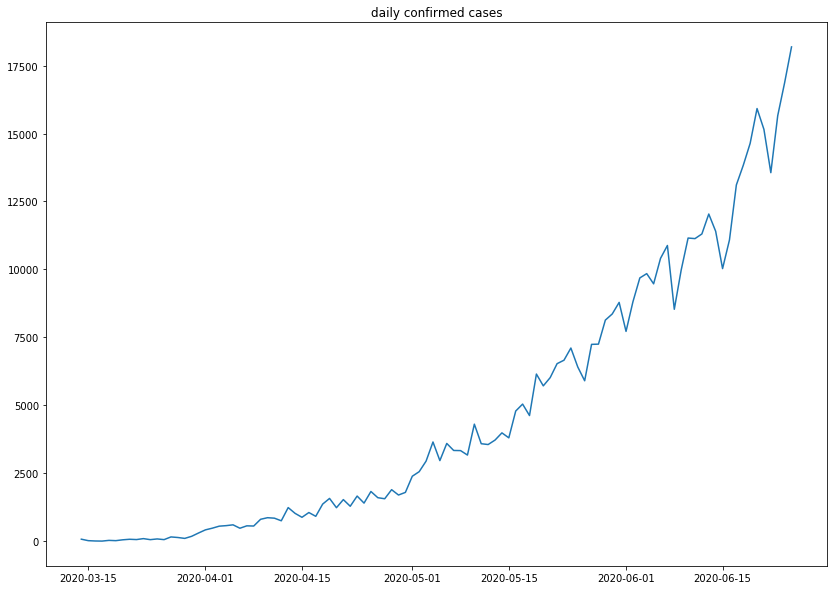

In [214]:
plt.plot(daily_conf_cases)
plt.title("daily confirmed cases");
daily_conf_cases.shape

In [215]:
test_data_size = 40

train_data = daily_conf_cases[:-test_data_size]
test_data = daily_conf_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(64,)
(40,)


In [216]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data[:, np.newaxis])
train_data = scaler.transform(train_data[:, np.newaxis])
test_data = scaler.transform(test_data[:, np.newaxis])
print(train_data[:5])
print(test_data[:5])

[[0.01463517]
 [0.00334518]
 [0.0008363 ]
 [0.        ]
 [0.00543592]]
[[1.05331382]
 [0.96529375]
 [1.28434037]
 [1.19360234]
 [1.2569517 ]]


In [217]:
def create_seq(data, seq_len):
    x = []
    y = []
    for i in range(len(data)-seq_len-1):
        x1 = data[i:(i+seq_len)]
        y1 = data[i+seq_len]
        x.append(x1)
        y.append(y1)
    return np.array(x), np.array(y)

In [218]:
seq_len = 5
xtrain, ytrain = create_seq(train_data, seq_len)
xtest, ytest = create_seq(test_data, seq_len)
xtrain = torch.from_numpy(xtrain).float()
ytrain = torch.from_numpy(ytrain).float()
xtest = torch.from_numpy(xtest).float()
ytest = torch.from_numpy(ytest).float()

In [219]:
print(xtrain.shape)
print(xtrain[:2])

torch.Size([58, 5, 1])
tensor([[[0.0146],
         [0.0033],
         [0.0008],
         [0.0000],
         [0.0054]],

        [[0.0033],
         [0.0008],
         [0.0000],
         [0.0054],
         [0.0033]]])


In [220]:
print(ytrain.shape)
print(ytrain[:2])

torch.Size([58, 1])
tensor([[0.0033],
        [0.0098]])


In [221]:
train_data[:10]

array([[0.01463517],
       [0.00334518],
       [0.0008363 ],
       [0.        ],
       [0.00543592],
       [0.00334518],
       [0.00982647],
       [0.01400794],
       [0.01170813],
       [0.01902572]])

In [222]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [223]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(xtrain)

    loss = loss_fn(y_pred.float(), ytrain)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(xtest)
        test_loss = loss_fn(y_test_pred.float(), ytest)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [224]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_len, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  xtrain, 
  ytrain, 
  xtest, 
  ytest
)

Epoch 0 train loss: 9.678001403808594 test loss: 176.15650939941406
Epoch 10 train loss: 4.231407165527344 test loss: 120.40226745605469
Epoch 20 train loss: 3.385899305343628 test loss: 65.27914428710938
Epoch 30 train loss: 2.1486175060272217 test loss: 87.88429260253906
Epoch 40 train loss: 2.833326816558838 test loss: 102.6440658569336
Epoch 50 train loss: 2.135822296142578 test loss: 191.32664489746094


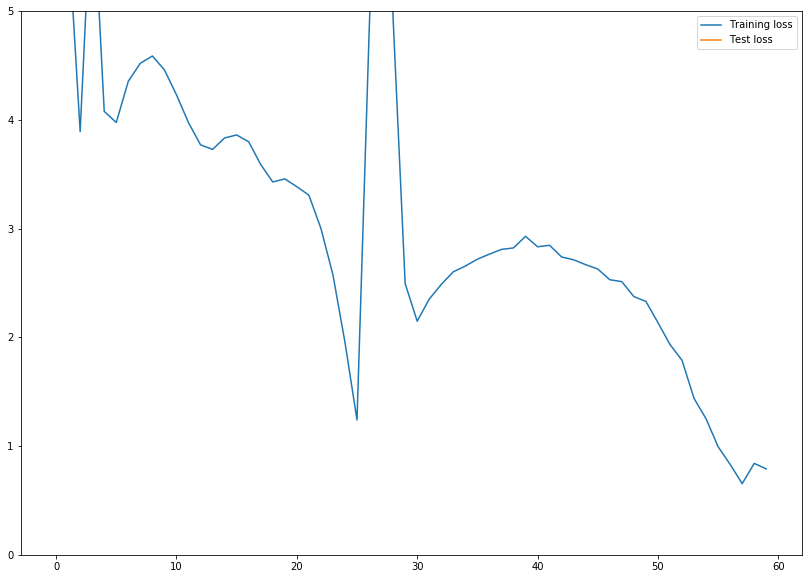

In [225]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [226]:
with torch.no_grad():
  test_seq = xtest[:1]
  preds = []
  for _ in range(len(xtest)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_len, 1).float()

In [227]:
true_cases = scaler.inverse_transform(
    np.expand_dims(ytest.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

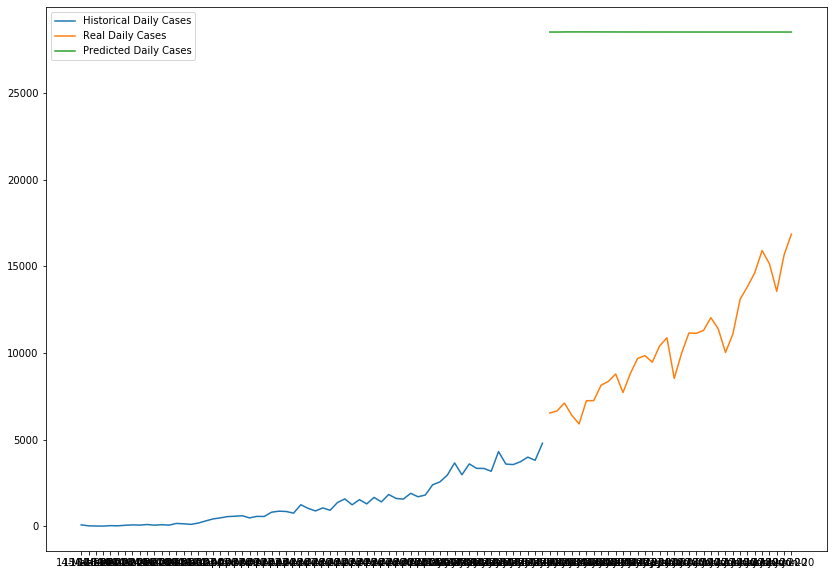

In [228]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [229]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(104, 1)

In [ ]:
X_all, y_all = create_sequences(all_data, seq_len)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_len, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 10.356760025024414
Epoch 10 train loss: 4.919162273406982
Epoch 20 train loss: 3.5613648891448975
Epoch 30 train loss: 1.8508116006851196
Epoch 40 train loss: 1.6259211301803589
Epoch 50 train loss: 1.2435511350631714


In [ ]:
DAYS_TO_PREDICT = 12
with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_len, 1).float()

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
daily_cases.index[-1]

In [ ]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [ ]:
plt.plot(daily_conf_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();